In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import keras.models
import keras.layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import gradio as gr

#regression
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, HuberRegressor, Lasso
from sklearn.metrics import make_scorer, mean_squared_error,confusion_matrix,accuracy_score
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR  
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV 

#Classification
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [2]:
#logger
logging.basicConfig(filename='logs.log', level=logging.INFO,format='%(asctime)s :: %(levelname)s :: %(message)s')

### Data Exploration

In [3]:
#reading and labeling data
def DataReading(filename):
    data=pd.read_csv(filename, sep=" ", header=None)
    # columns list
    COLS = ["ID", "Cycle", "OpSet1", "OpSet2", "OpSet3", "SensorMeasure1", "SensorMeasure2", "SensorMeasure3", "SensorMeasure4",
                "SensorMeasure5", "SensorMeasure6", "SensorMeasure7", "SensorMeasure8", "SensorMeasure9", "SensorMeasure10", "SensorMeasure11",
                "SensorMeasure12", "SensorMeasure13", "SensorMeasure14", "SensorMeasure15", "SensorMeasure16",
                "SensorMeasure17", "SensorMeasure18", "SensorMeasure19", "SensorMeasure20", "SensorMeasure21"]
    data =data[[f for f in range(0, 26)]]
    data.columns = ["ID", "Cycle", "OpSet1", "OpSet2", "OpSet3", "SensorMeasure1", "SensorMeasure2", "SensorMeasure3", "SensorMeasure4",
                "SensorMeasure5", "SensorMeasure6", "SensorMeasure7", "SensorMeasure8", "SensorMeasure9", "SensorMeasure10", "SensorMeasure11",
                "SensorMeasure12", "SensorMeasure13", "SensorMeasure14", "SensorMeasure15", "SensorMeasure16",
                "SensorMeasure17", "SensorMeasure18", "SensorMeasure19", "SensorMeasure20", "SensorMeasure21"]
    return data
    



#train data
train_data=DataReading("Dataset/train_FD001.txt")

#test data
test_data=DataReading("Dataset/test_FD001.txt")

logging.info("Training and Test Data Collection and labeling complete")


In [4]:
# reading Rul of last cycle of each engin for test data
#reading data train data

Rul_data=pd.read_csv("Dataset/RUL_FD001.txt", sep=" ", header=None)
Rul_data["ID"] = Rul_data.index + 1
Rul_data=Rul_data.rename(columns={0:"RUL"}).drop(1,axis=1)
Rul_data
logging.info("Remaining Usefull life of Test Data set reading/Loading complete")

THIS THE RUL OF LAST CYCLE OF DIFFRENT ENGINS OF TEST DATA

### Preprocessing

In [7]:
# maximun number of engines cycle in train data
max_cycles_df_train = train_data.groupby(["ID"], sort=False)["Cycle"].max().reset_index().rename(columns={"Cycle" : "MaxCycleID"})
max_cycles_df_train



# Calculating RUL form the max_cycles_df in train data
train_data = pd.merge(train_data, max_cycles_df_train, how="inner", on="ID")
train_data["RUL"] = train_data["MaxCycleID"] - train_data["Cycle"]
train_data.drop('MaxCycleID',inplace=True, axis=1)
train_data.head()

#coverting into binary Rul 
# 1 for okay
# 0 for not Okay
binary_RUL=train_data['RUL'].map(lambda x: 1 if x>=20 else 0)
train_data['Binary_RUL']=binary_RUL
pro_train_data=train_data
pro_train_data


ID  Cycle  OpSet1  OpSet2  OpSet3  SensorMeasure1  SensorMeasure2  \
0        1      1 -0.0007 -0.0004   100.0          518.67          641.82   
1        1      2  0.0019 -0.0003   100.0          518.67          642.15   
2        1      3 -0.0043  0.0003   100.0          518.67          642.35   
3        1      4  0.0007  0.0000   100.0          518.67          642.35   
4        1      5 -0.0019 -0.0002   100.0          518.67          642.37   
...    ...    ...     ...     ...     ...             ...             ...   
20626  100    196 -0.0004 -0.0003   100.0          518.67          643.49   
20627  100    197 -0.0016 -0.0005   100.0          518.67          643.54   
20628  100    198  0.0004  0.0000   100.0          518.67          643.42   
20629  100    199 -0.0011  0.0003   100.0          518.67          643.23   
20630  100    200 -0.0032 -0.0005   100.0          518.67          643.85   

       SensorMeasure3  SensorMeasure4  SensorMeasure5  ...  SensorMeasure14  \
0             1589.70         1400.60           14.62  ...          8138.62   
1             1591.82         1403.14           14.62  ...          8131.49   
2             1587.99         1404.20           14.62  ...          8133.23   
3             1582.79         1401.87           14.62  ...          8133.83   
4             1582.85         1406.22           14.62  ...          8133.80   
...               ...             ...             ...  ...              ...   
20626         1597.98         1428.63           14.62  ...          8137.60   
20627         1604.50         1433.58           14.62  ...          8136.50   
20628         1602.46         1428.18           14.62  ...          8141.05   
20629         1605.26         1426.53           14.62  ...          8139.29   
20630         1600.38         1432.14           14.62  ...          8137.33   

       SensorMeasure15  SensorMeasure16  SensorMeasure17  SensorMeasure18  \
0               8.4195             0.03              392             2388   
1               8.4318             0.03              392             2388   
2               8.4178             0.03              390             2388   
3               8.3682             0.03              392             2388   
4               8.4294             0.03              393             2388   
...                ...              ...              ...              ...   
20626           8.4956             0.03              397             2388   
20627           8.5139             0.03              395             2388   
20628           8.5646             0.03              398             2388   
20629           8.5389             0.03              395             2388   
20630           8.5036             0.03              396             2388   

       SensorMeasure19  SensorMeasure20  SensorMeasure21  RUL  Binary_RUL  
0                100.0            39.06          23.4190  191           1  
1                100.0            39.00          23.4236  190           1  
2                100.0            38.95          23.3442  189           1  
3                100.0            38.88          23.3739  188           1  
4                100.0            38.90          23.4044  187           1  
...                ...              ...              ...  ...         ...  
20626            100.0            38.49          22.9735    4           0  
20627            100.0            38.30          23.1594    3           0  
20628            100.0            38.44          22.9333    2           0  
20629            100.0            38.29          23.0640    1           0  
20630            100.0            38.37          23.0522    0           0  

[20631 rows x 28 columns]

In [6]:
# maximun number of engines cycle in test data
max_cycles_df_test = test_data.copy(deep=True).groupby(['ID'])["Cycle"].max().reset_index()
max_cycles_df_test

test_data = pd.merge(test_data, max_cycles_df_test, how="inner", on=["ID",'Cycle'])
test_data["RUL"]=Rul_data["RUL"]

#coverting into binary Rul 
# 1 for okay
# 0 for not Okay
binary_RUL=test_data['RUL'].map(lambda x: 1 if x>=20 else 0)
test_data['Binary_RUL']=binary_RUL
pro_test_data=test_data
logging.info("Testing Data Set Binary coversion of RUL complete")
pro_test_data

ID  Cycle  OpSet1  OpSet2  OpSet3  SensorMeasure1  SensorMeasure2  \
0     1     31 -0.0006  0.0004   100.0          518.67          642.58   
1     2     49  0.0018 -0.0001   100.0          518.67          642.55   
2     3    126 -0.0016  0.0004   100.0          518.67          642.88   
3     4    106  0.0012  0.0004   100.0          518.67          642.78   
4     5     98 -0.0013 -0.0004   100.0          518.67          642.27   
..  ...    ...     ...     ...     ...             ...             ...   
95   96     97 -0.0006  0.0003   100.0          518.67          642.30   
96   97    134  0.0013 -0.0001   100.0          518.67          642.59   
97   98    121  0.0017  0.0001   100.0          518.67          642.68   
98   99     97  0.0047 -0.0000   100.0          518.67          642.00   
99  100    198  0.0013  0.0003   100.0          518.67          642.95   

    SensorMeasure3  SensorMeasure4  SensorMeasure5  ...  SensorMeasure14  \
0          1581.22         1398.91           14.62  ...          8130.11   
1          1586.59         1410.83           14.62  ...          8126.90   
2          1589.75         1418.89           14.62  ...          8131.46   
3          1594.53         1406.88           14.62  ...          8133.64   
4          1589.94         1419.36           14.62  ...          8125.74   
..             ...             ...             ...  ...              ...   
95         1590.88         1397.94           14.62  ...          8148.24   
96         1582.96         1410.92           14.62  ...          8155.48   
97         1599.51         1415.47           14.62  ...          8146.39   
98         1585.03         1397.98           14.62  ...          8150.38   
99         1601.62         1424.99           14.62  ...          8214.64   

    SensorMeasure15  SensorMeasure16  SensorMeasure17  SensorMeasure18  \
0            8.4024             0.03              393             2388   
1            8.4505             0.03              391             2388   
2            8.4119             0.03              395             2388   
3            8.4634             0.03              395             2388   
4            8.4362             0.03              394             2388   
..              ...              ...              ...              ...   
95           8.4110             0.03              391             2388   
96           8.4500             0.03              395             2388   
97           8.4235             0.03              394             2388   
98           8.4003             0.03              391             2388   
99           8.4903             0.03              396             2388   

    SensorMeasure19  SensorMeasure20  SensorMeasure21  RUL  Binary_RUL  
0             100.0            38.81          23.3552  112           1  
1             100.0            38.81          23.2618   98           1  
2             100.0            38.93          23.2740   69           1  
3             100.0            38.58          23.2581   82           1  
4             100.0            38.75          23.4117   91           1  
..              ...              ...              ...  ...         ...  
95            100.0            38.96          23.4606  137           1  
96            100.0            38.61          23.2953   82           1  
97            100.0            38.76          23.3608   59           1  
98            100.0            38.95          23.3595  117           1  
99            100.0            38.70          23.1855   20           1  

[100 rows x 28 columns]

C:\Users\Raj\AppData\Local\Temp\ipykernel_20992\1573044050.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


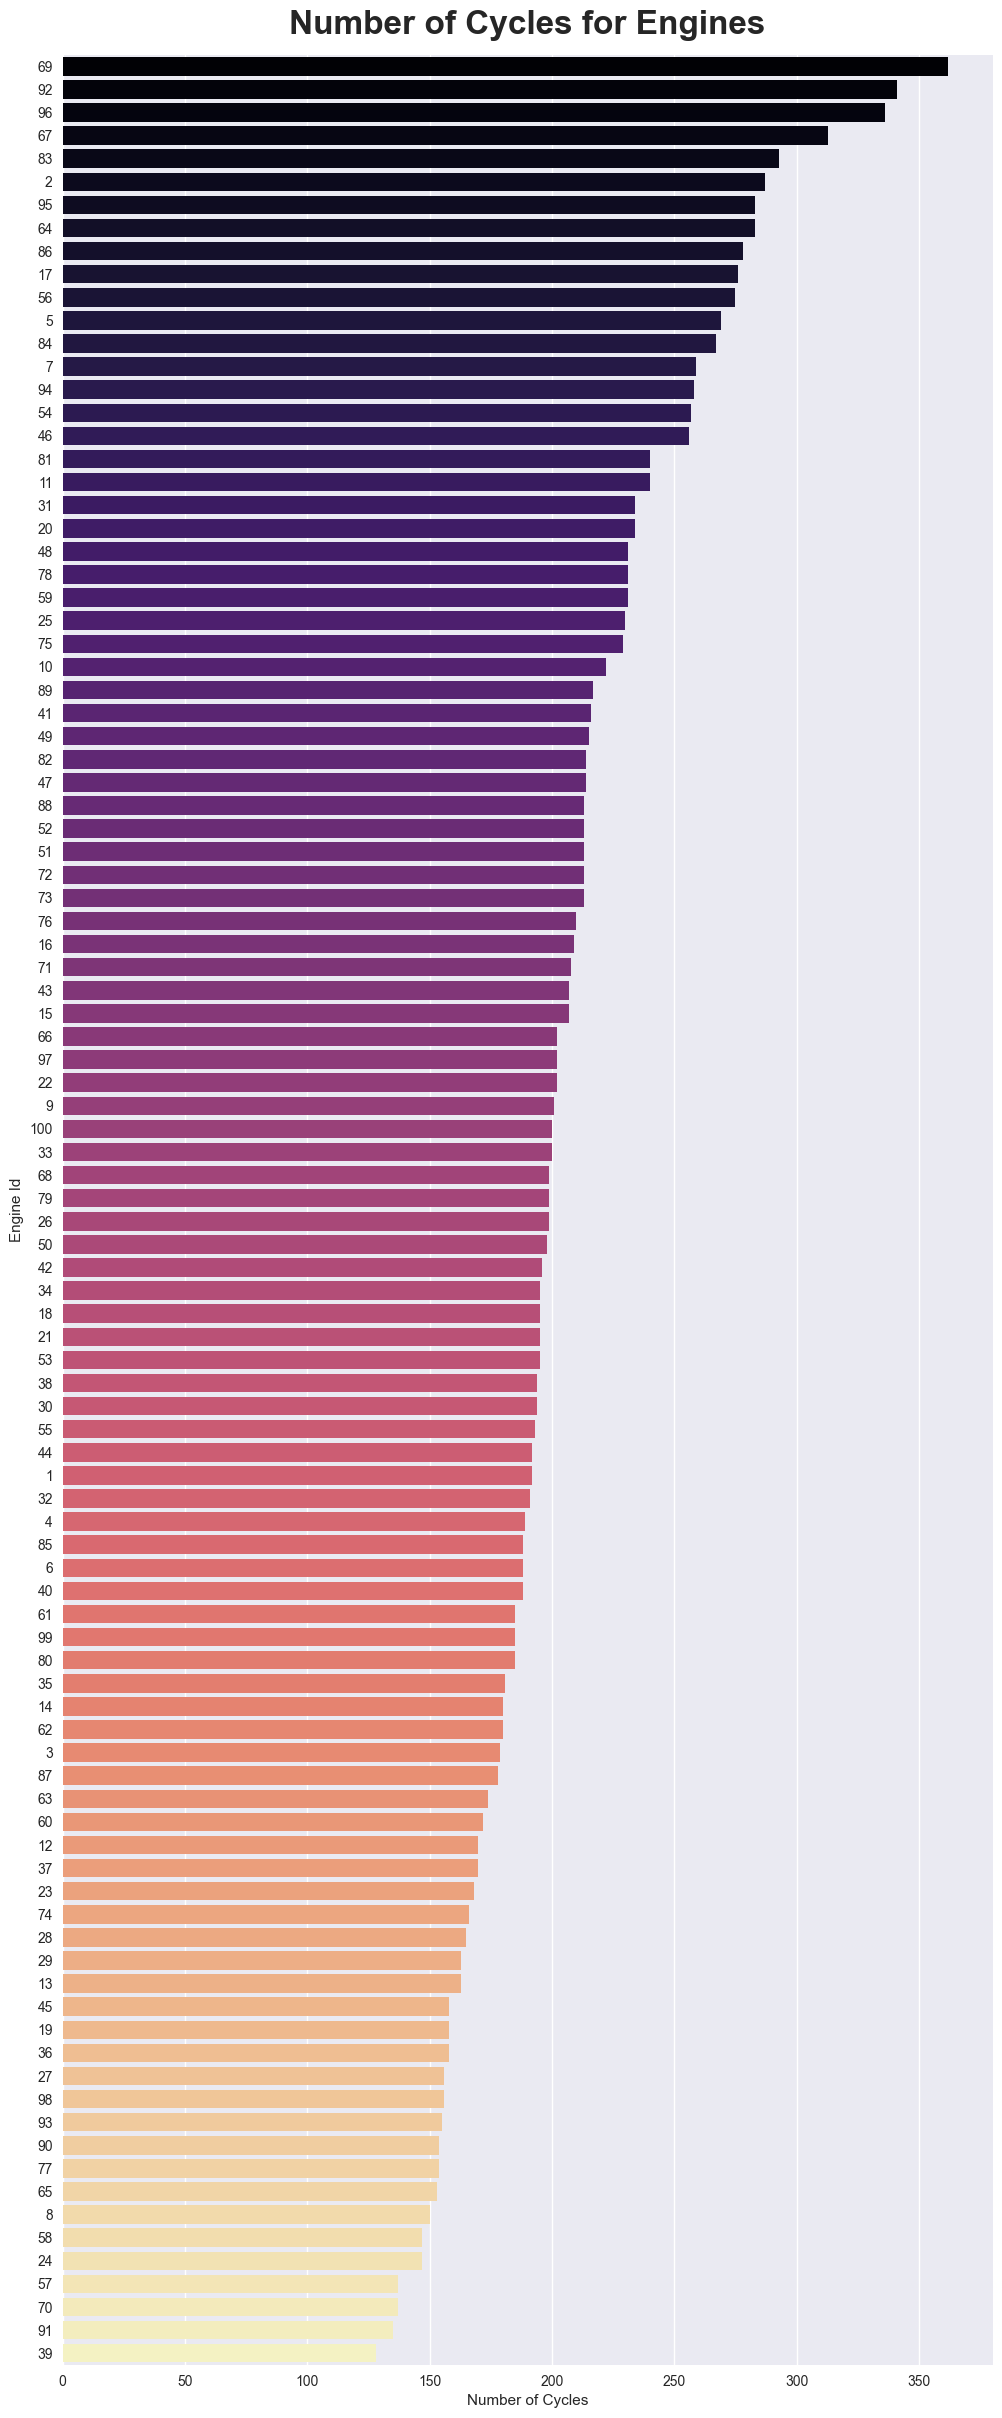

In [12]:
cnt_train = train_data[["ID", "Cycle"]].groupby("ID").max().sort_values(by="Cycle", ascending=False)
cnt_ind = [str(i) for i in cnt_train.index.to_list()]
cnt_val = list(cnt_train.Cycle.values)

plt.style.use("seaborn")
plt.figure(figsize=(12, 30))
sns.barplot(x=list(cnt_val), y=list(cnt_ind), palette='magma')
plt.xlabel('Number of Cycles')
plt.ylabel('Engine Id')
plt.title('Number of Cycles for Engines', fontweight='bold', fontsize=24, pad=15)

plt.show()

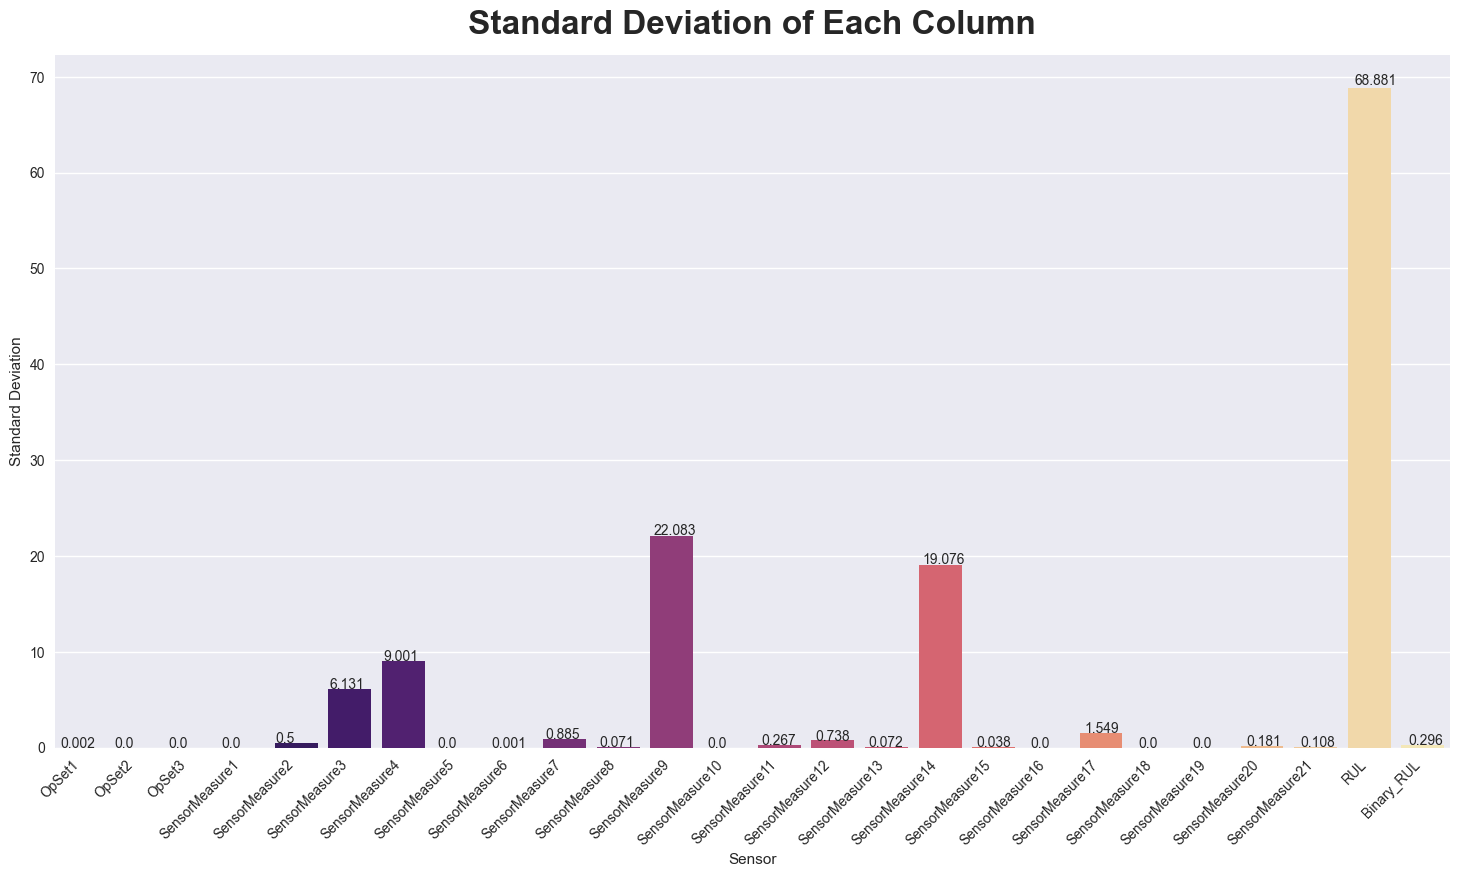

In [13]:
plt.figure(figsize=(18, 9))
subset_stats = train_data.agg(['mean', 'std']).T[2:]
ax = sns.barplot(x=subset_stats.index, y="std", data=subset_stats, palette='magma')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xlabel("Sensor")
ax.set_ylabel("Standard Deviation")
ax.set_title("Standard Deviation of Each Column", fontweight='bold', fontsize=24, pad=15)

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

In [7]:
pd.set_option('display.max_columns', None)
pro_test_data

ID  Cycle  OpSet1  OpSet2  OpSet3  SensorMeasure1  SensorMeasure2  \
0     1     31 -0.0006  0.0004   100.0          518.67          642.58   
1     2     49  0.0018 -0.0001   100.0          518.67          642.55   
2     3    126 -0.0016  0.0004   100.0          518.67          642.88   
3     4    106  0.0012  0.0004   100.0          518.67          642.78   
4     5     98 -0.0013 -0.0004   100.0          518.67          642.27   
..  ...    ...     ...     ...     ...             ...             ...   
95   96     97 -0.0006  0.0003   100.0          518.67          642.30   
96   97    134  0.0013 -0.0001   100.0          518.67          642.59   
97   98    121  0.0017  0.0001   100.0          518.67          642.68   
98   99     97  0.0047 -0.0000   100.0          518.67          642.00   
99  100    198  0.0013  0.0003   100.0          518.67          642.95   

    SensorMeasure3  SensorMeasure4  SensorMeasure5  SensorMeasure6  \
0          1581.22         1398.91           14.62           21.61   
1          1586.59         1410.83           14.62           21.61   
2          1589.75         1418.89           14.62           21.61   
3          1594.53         1406.88           14.62           21.61   
4          1589.94         1419.36           14.62           21.61   
..             ...             ...             ...             ...   
95         1590.88         1397.94           14.62           21.61   
96         1582.96         1410.92           14.62           21.61   
97         1599.51         1415.47           14.62           21.61   
98         1585.03         1397.98           14.62           21.61   
99         1601.62         1424.99           14.62           21.61   

    SensorMeasure7  SensorMeasure8  SensorMeasure9  SensorMeasure10  \
0           554.42         2388.08         9056.40              1.3   
1           553.52         2388.10         9044.77              1.3   
2           552.59         2388.16         9049.26              1.3   
3           552.64         2388.13         9051.30              1.3   
4           553.29         2388.10         9053.99              1.3   
..             ...             ...             ...              ...   
95          553.99         2388.03         9062.41              1.3   
96          554.05         2388.06         9076.36              1.3   
97          553.44         2388.13         9062.34              1.3   
98          554.75         2388.01         9067.16              1.3   
99          552.48         2388.06         9155.03              1.3   

    SensorMeasure11  SensorMeasure12  SensorMeasure13  SensorMeasure14  \
0             47.23           521.79          2388.06          8130.11   
1             47.67           521.74          2388.09          8126.90   
2             47.88           520.83          2388.14          8131.46   
3             47.65           521.88          2388.11          8133.64   
4             47.46           521.00          2388.15          8125.74   
..              ...              ...              ...              ...   
95            47.14           522.30          2388.01          8148.24   
96            47.38           521.58          2388.06          8155.48   
97            47.66           521.53          2388.09          8146.39   
98            47.26           521.82          2388.02          8150.38   
99            47.80           521.07          2388.05          8214.64   

    SensorMeasure15  SensorMeasure16  SensorMeasure17  SensorMeasure18  \
0            8.4024             0.03              393             2388   
1            8.4505             0.03              391             2388   
2            8.4119             0.03              395             2388   
3            8.4634             0.03              395             2388   
4            8.4362             0.03              394             2388   
..              ...              ...              ...              ...   
95           8.

### Analysing Data & feature selection


C:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


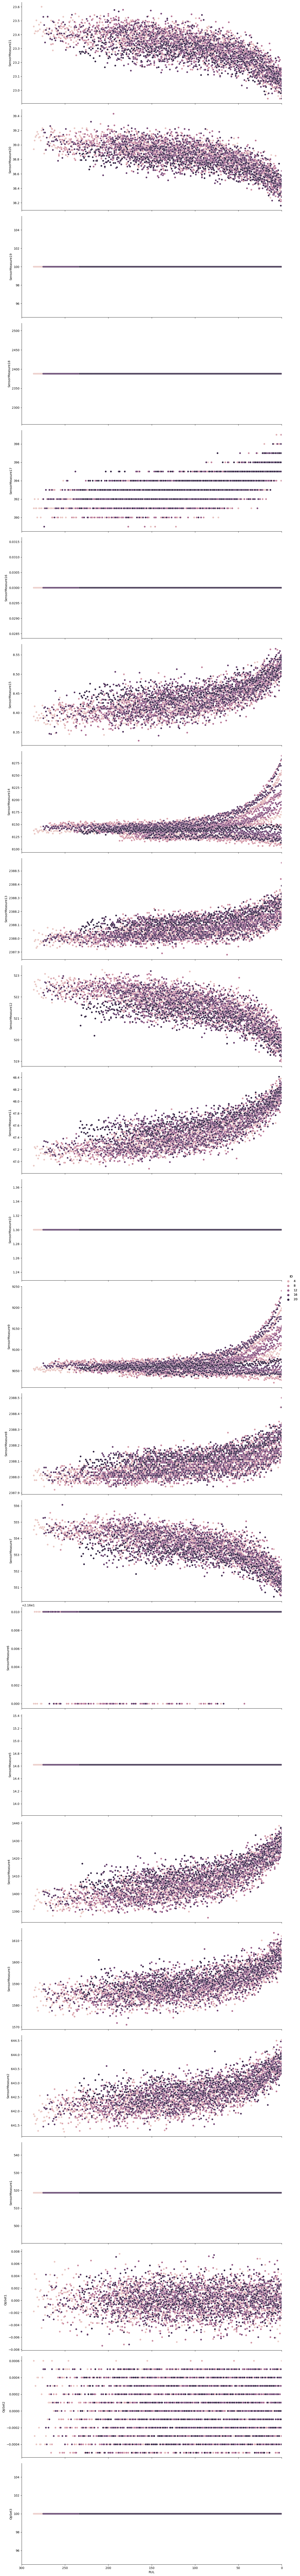

In [8]:
#showing relation with each featues and RUL

sns.pairplot(pro_train_data[pro_train_data['ID']<=20],hue='ID'
             ,x_vars='RUL'
             , y_vars=['SensorMeasure21','SensorMeasure20','SensorMeasure19',
                       'SensorMeasure18','SensorMeasure17','SensorMeasure16',
                       'SensorMeasure15','SensorMeasure14','SensorMeasure13',
                       'SensorMeasure12','SensorMeasure11','SensorMeasure10',
                       'SensorMeasure9','SensorMeasure8','SensorMeasure7',
                       'SensorMeasure6','SensorMeasure5','SensorMeasure4',
                       'SensorMeasure3','SensorMeasure2','SensorMeasure1',
                       'OpSet1','OpSet2','OpSet3']
             ,kind='scatter', diag_kind='auto', markers=None,size=5, aspect=2.5).set(xlim=(300,0)).add_legend()
logging.info("Analysing Data for feature selection by findind relation with featues and RUL complete")

From the above graphs we can see that opset3 ,SensorMeasure 1,5,6,10,16,18,19 are constant for diffrent RULs.
so these features will not be use full for the training.

### Train and Test Sub Set For Training and testing

In [9]:
#droping opset3 ,SensorMeasure 1,5,6,10,16,18,19 from train data set
# making x_test y_test x_train  y_train

X_train=pro_train_data.drop(["ID","OpSet3","OpSet2","OpSet1","RUL","Binary_RUL",'SensorMeasure1','SensorMeasure5','SensorMeasure6','SensorMeasure10','SensorMeasure16','SensorMeasure18','SensorMeasure19'],axis=1)

X_test=pro_test_data.drop(["ID","OpSet3","OpSet2","OpSet1","RUL","Binary_RUL",'SensorMeasure1','SensorMeasure5','SensorMeasure6','SensorMeasure10','SensorMeasure18','SensorMeasure16','SensorMeasure19'],axis=1)


logging.info("Train and Test data divide into X_train and X_test")
logging.info('y_test and y_train are used for classification and Regression')
logging.info("value of y_test and y_train are assigined in the Model selction ")

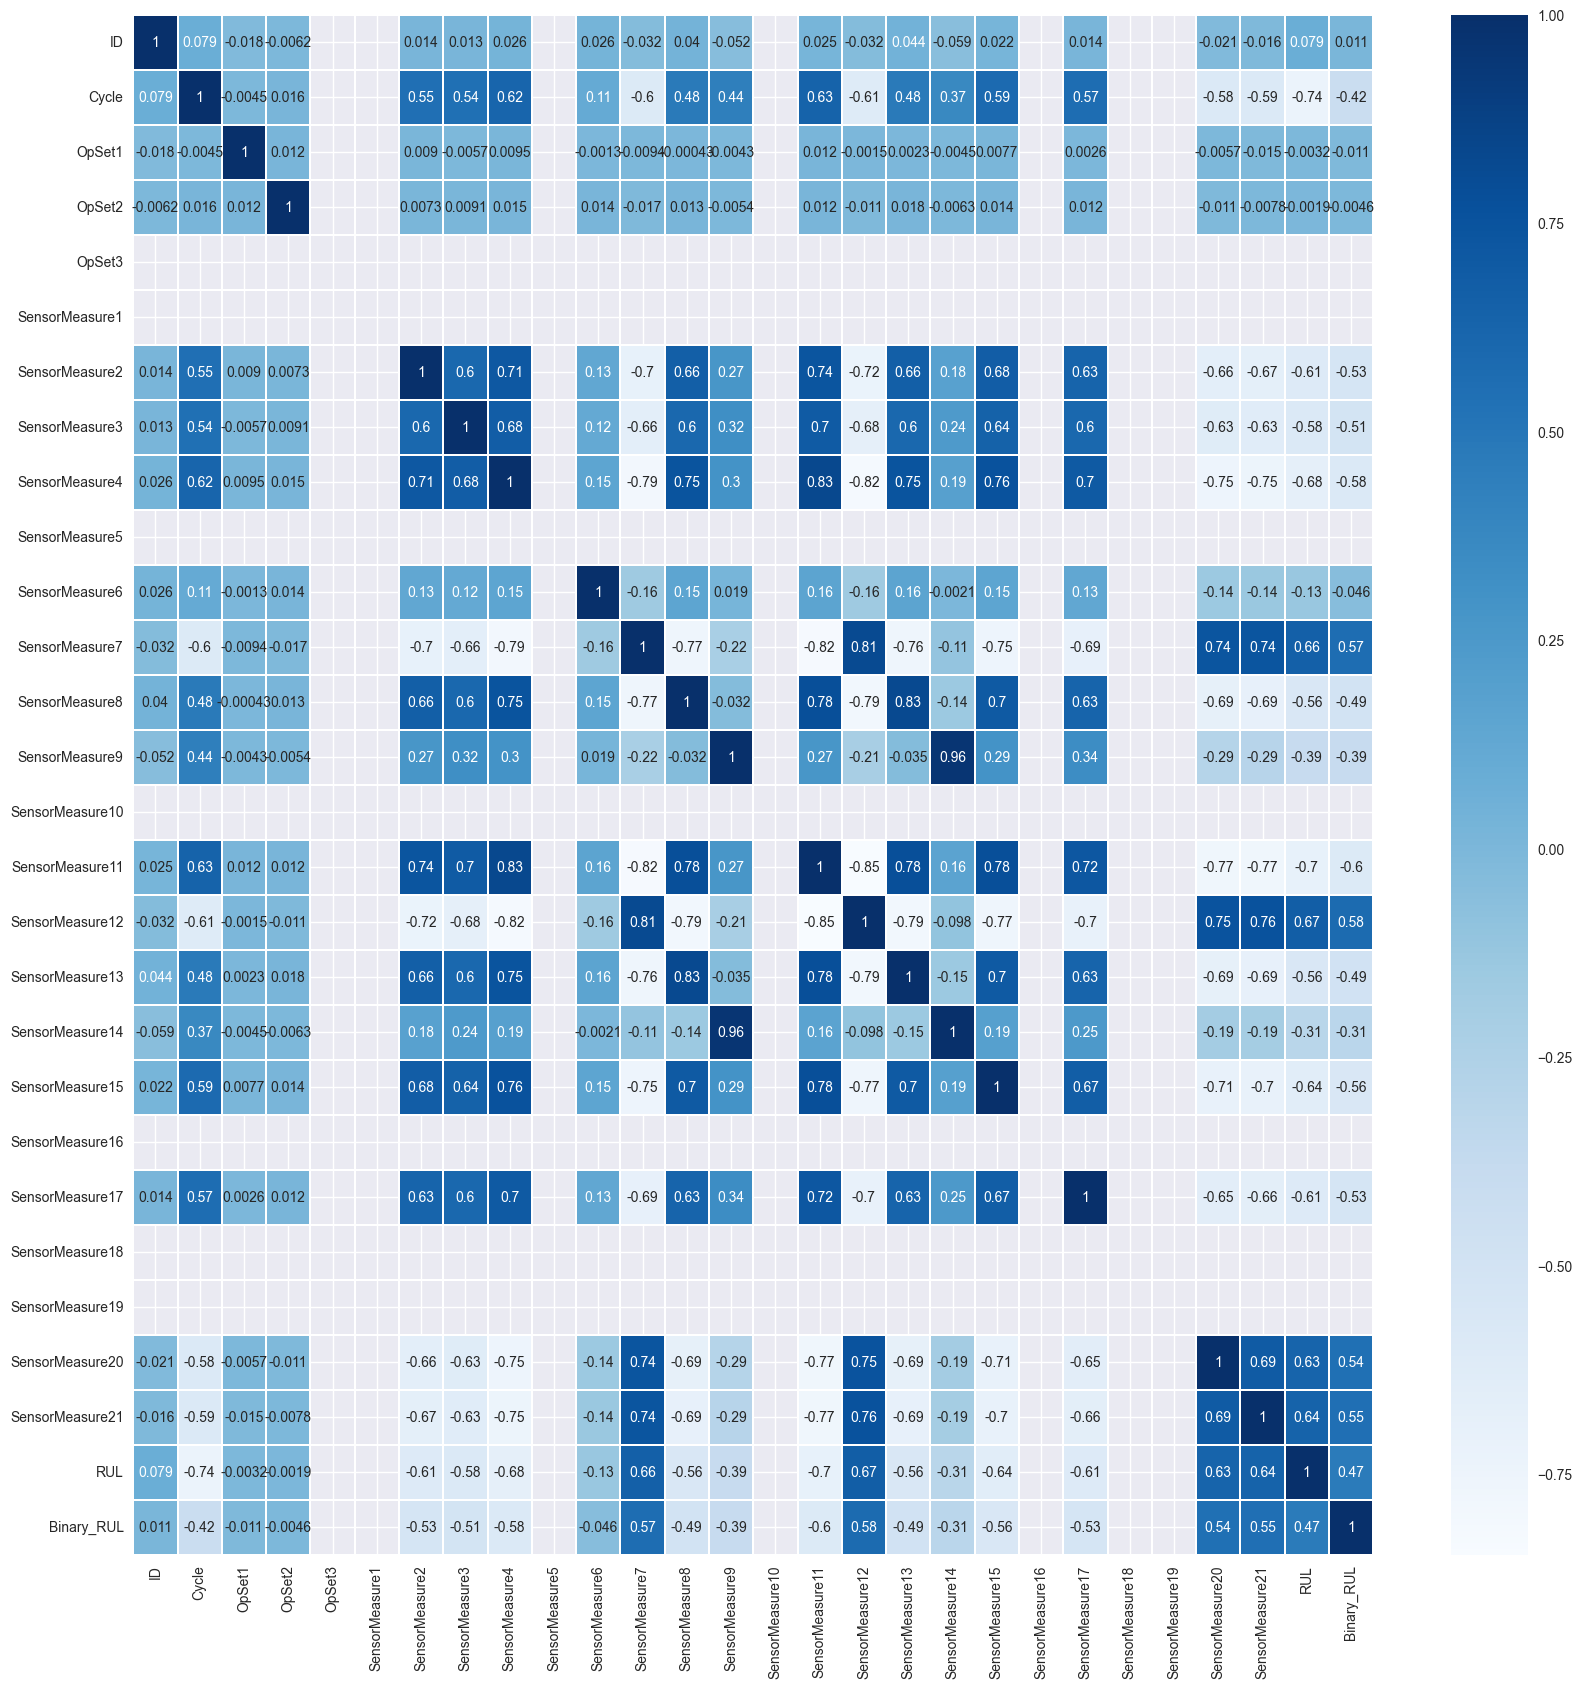

In [15]:
sns.heatmap(pro_train_data.corr(),annot=True,cmap='Blues',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

### Feature scaling

In [10]:
from sklearn.preprocessing import StandardScaler    
st_x= StandardScaler()    
X_train= st_x.fit_transform(X_train)    
X_test= st_x.transform(X_test)

logging.info("Scaling Train and Test data completed")

### Model Selection for RUL

C:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Squared Error
SVM                     563.761323
Neural Network          620.037434
RandomForest            734.613283
Huber                   796.409264
Bagging                 903.229800
BayesianRidge           968.347954
Ridge                   968.987049
Linear                  969.011725
Lasso                   974.544430
AdaBoost               1313.327238

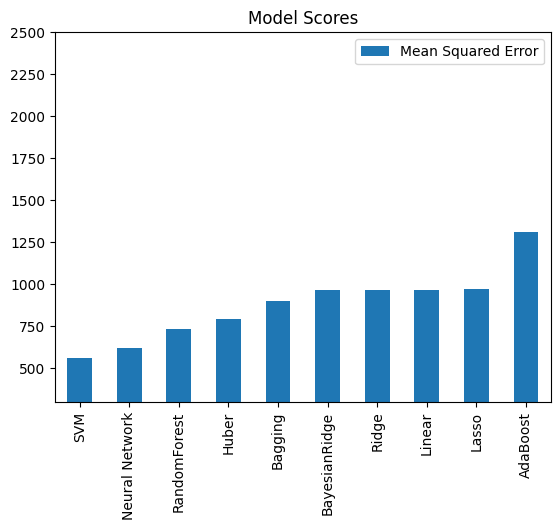

In [11]:
# RUL Model selection (Regression)

y_train=pro_train_data['RUL']

y_test=pro_test_data["RUL"]

logging.info("y_train and y_test assigined with RUL Value From The Train & Test Data set ")

def analyse_regression_models(train, labels):
    results = {}
    
    def test_model(clf):
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        mse =mean_squared_error(y_pred,y_test)
        
        return mse
    
    clf = LinearRegression()
    results["Linear"] = test_model(clf)
    
    clf = Ridge()
    results["Ridge"] = test_model(clf)
    
    clf = BayesianRidge()
    results["BayesianRidge"] = test_model(clf)
    
    clf = HuberRegressor()
    results["Huber"] = test_model(clf)
    
    clf = Lasso()
    results["Lasso"] = test_model(clf)
    
    clf = MLPRegressor()
    results["Neural Network"] = test_model(clf)
    
    clf = BaggingRegressor()
    results["Bagging"] = test_model(clf)
    
    clf = RandomForestRegressor()
    results["RandomForest"] = test_model(clf)
    
    clf = AdaBoostRegressor()
    results["AdaBoost"] = test_model(clf)
    
    clf = SVR()
    results["SVM"] = test_model(clf)
    
    #logger
    logging.info("Find the best model for Regression which have lowest MSE")
    
    results = pd.DataFrame.from_dict(results, orient='index')
    results.columns = ["Mean Squared Error"] 
    results = results.sort_values(by=["Mean Squared Error"], ascending=True)
    results.plot(kind="bar", title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([300, 2500])
    return results

analyse_regression_models(X_train, y_train)



### Accuracy of SVM Model (SVR)

In [12]:
logging.info("Best Model Found 'SVR' has lowest  ")

clf=SVR(kernel ='rbf',C=0.056 ,epsilon=0.86)
clf.fit(X_train,y_train)
score=clf.score(X_test,y_test)
score

0.7187535841535271

### Predcition of engine faliure after 20 days

LogisticRegression

 Confusion Matrix  
 
 [[11  2]
 [ 1 86]]


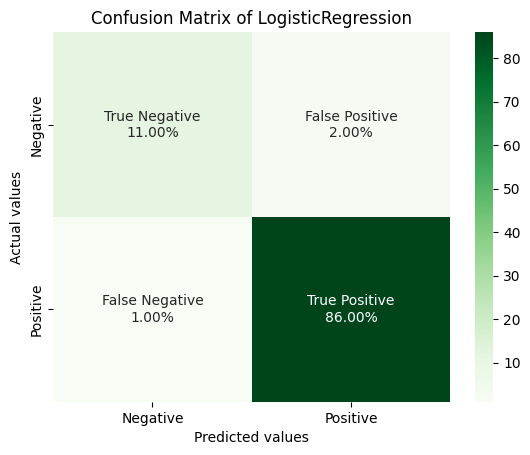

Naive Bayse

 Confusion Matrix  
 
 [[12  1]
 [ 8 79]]


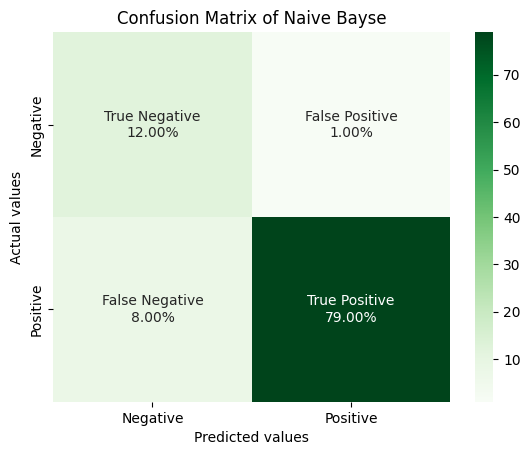

KNeighbors

 Confusion Matrix  
 
 [[11  2]
 [ 1 86]]


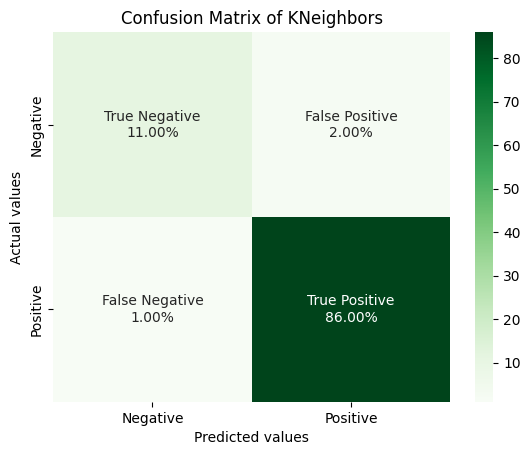

SVC

 Confusion Matrix  
 
 [[11  2]
 [ 3 84]]


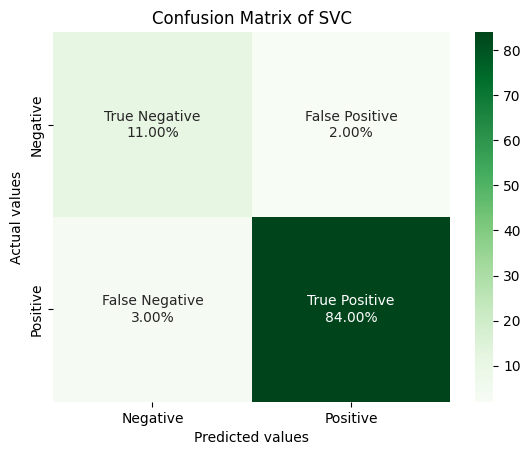

QuadraticDiscriminantAnalysis

 Confusion Matrix  
 
 [[11  2]
 [ 5 82]]


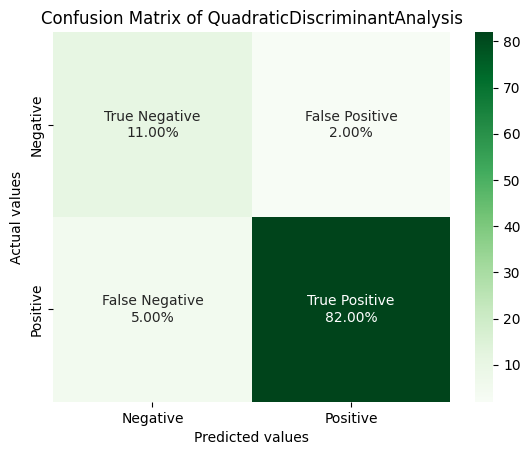

Neural Network

 Confusion Matrix  
 
 [[11  2]
 [ 2 85]]


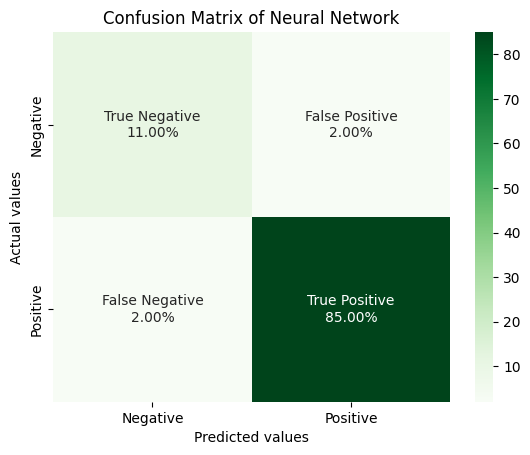

AdaBoost

 Confusion Matrix  
 
 [[12  1]
 [ 2 85]]


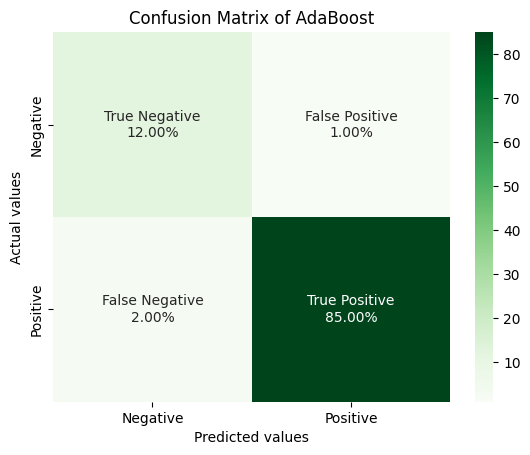

Decision Tree

 Confusion Matrix  
 
 [[10  3]
 [ 2 85]]


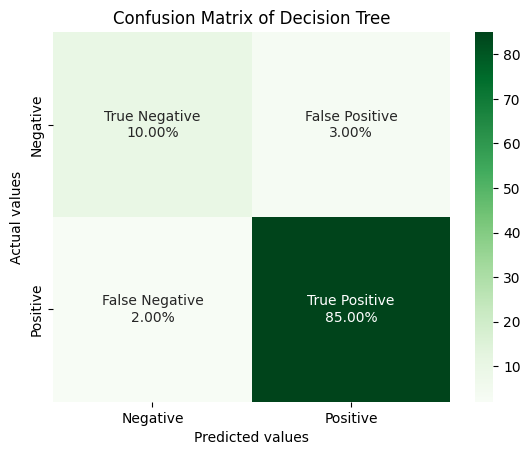

RandomForest

 Confusion Matrix  
 
 [[ 9  4]
 [ 3 84]]


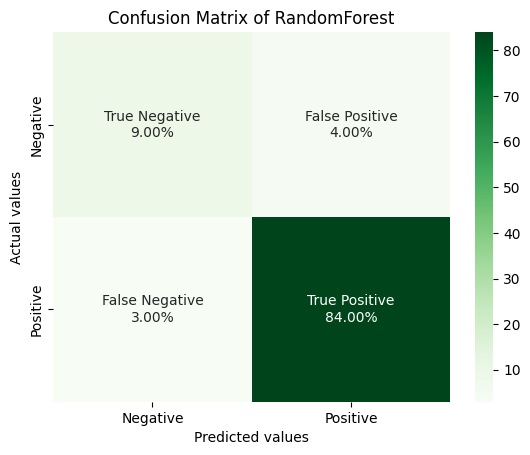

Accuracy
LogisticRegression                 0.97
KNeighbors                         0.97
AdaBoost                           0.97
Neural Network                     0.96
SVM                                0.95
Decision Tree                      0.95
QuadraticDiscriminantAnalysis      0.93
RandomForest                       0.93
Naive Bayse                        0.91

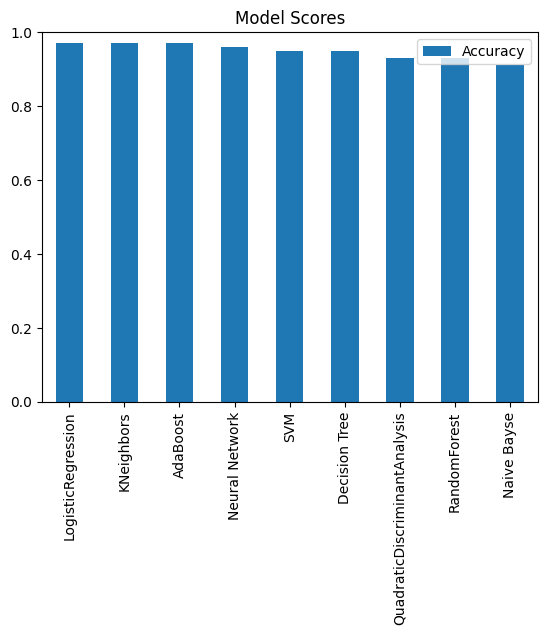

In [14]:
import numpy as np
# Model selection (Binary classification)

X_train_bin=X_train
X_test_bin=X_test
y_train_bin=pro_train_data['Binary_RUL']
y_test_bin=pro_test_data["Binary_RUL"]

def analyse_binary_classification_models(train, labels):
    results = {}
    
    def c_matrix(y_true,y_pred,name):
        c_matrix = confusion_matrix(y_true,y_pred)
        print("\n Confusion Matrix  \n \n",c_matrix)
        categories = ['Negative','Positive']
        prediction = ['True Negative','False Positive', 'False Negative','True Positive']
        percentage = ['{0:.2%}'.format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]
        lab = [f'{m}\n{n}' for m, n in zip(prediction,percentage)]
        lab = np.asarray(lab).reshape(2,2)
        sns.heatmap(c_matrix,cmap = 'Greens' , fmt = '',annot = lab, xticklabels = categories, yticklabels = categories)
        plt.xlabel("Predicted values")
        plt.ylabel("Actual values")
        plt.title ("Confusion Matrix of " + name)
        plt.show()
        
    def test_model(clf,m_name):
        clf.fit(train, labels)
        y_pred_bin=clf.predict(X_test_bin)
        scores=accuracy_score(y_test_bin, y_pred_bin)
        c_matrix(y_test_bin,y_pred_bin,m_name)
        return scores 
    
    clf=LogisticRegression()
    print("LogisticRegression")
    results["LogisticRegression"]= test_model(clf,"LogisticRegression")
    
    clf= GaussianNB()
    print("Naive Bayse")
    results["Naive Bayse"]= test_model(clf,"Naive Bayse")
    
    
    clf = KNeighborsClassifier(3)
    print("KNeighbors")
    results["KNeighbors"] = test_model(clf,"KNeighbors")
    
    clf = SVC()
    print("SVC")
    results["SVM"] = test_model(clf,"SVC")
 
    clf = QuadraticDiscriminantAnalysis()
    print("QuadraticDiscriminantAnalysis")
    results["QuadraticDiscriminantAnalysis"] = test_model(clf,"QuadraticDiscriminantAnalysis")
    
    clf = MLPClassifier(alpha=1)
    print("Neural Network")
    results["Neural Network"] = test_model(clf,"Neural Network")
    
    clf = AdaBoostClassifier()
    print("AdaBoost")
    results["AdaBoost"] = test_model(clf,"AdaBoost")
    
    clf = DecisionTreeClassifier(max_depth=5)
    print("Decision Tree")
    results["Decision Tree"] = test_model(clf,"Decision Tree")
    
    clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
    print("RandomForest")
    results["RandomForest"] = test_model(clf,"RandomForest")
    
    results = pd.DataFrame.from_dict(results, orient='index')
    results.columns = ["Accuracy"] 
    results = results.sort_values(by=["Accuracy"], ascending=False)
    results.plot(kind="bar", title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([0, 1])
    return results

analyse_binary_classification_models(X_train_bin, y_train_bin)

### USER INTERFACE

To Check Engine's Condition

In [15]:
X_train_bin=X_train
y_train_bin=pro_train_data['Binary_RUL']

def predict_RUL_Binary(
    Cycle,
    SensorMeasure2,
    SensorMeasure3,
    SensorMeasure4,
    SensorMeasure7,
    SensorMeasure8,
    SensorMeasure9,
    SensorMeasure11,
    SensorMeasure12, 
    SensorMeasure13,
    SensorMeasure14, 
    SensorMeasure15, 
    SensorMeasure17,
    SensorMeasure20,
    SensorMeasure21):
   
    
    input_data=[Cycle,
    SensorMeasure2,
    SensorMeasure3,
    SensorMeasure4,
    SensorMeasure7,
    SensorMeasure8,
    SensorMeasure9,
    SensorMeasure11,
    SensorMeasure12, 
    SensorMeasure13,
    SensorMeasure14, 
    SensorMeasure15, 
    SensorMeasure17,
    SensorMeasure20,
    SensorMeasure21]
    
    print(input_data)

    a = np.array(input_data)
    a=np.reshape(a,(1, a.size))
    a= st_x.transform(a)
    clf_reg=SVR(kernel ='rbf',C=0.056 ,epsilon=0.86)
    clf_reg.fit(X_train,y_train)
    RUL=clf_reg.predict(a)
    print(RUL)
    
    clf_bin=LogisticRegression() 
    clf_bin.fit(X_train_bin, y_train_bin)
    RUL_Binary=clf_bin.predict(a)
    mapping=lambda x: "Engine Is Okay" if x==1 else "Engine Is Not Okay"
    return mapping(RUL_Binary) ,int(RUL)
    
UIF=gr.Interface(predict_RUL_Binary,
             [  gr.inputs.Number(label="Cycle"), 
                gr.inputs.Number(label="SensorMeasure2"), 
                gr.inputs.Number(label="SensorMeasure3"), 
                gr.inputs.Number(label="SensorMeasure4"), 
                gr.inputs.Number(label="SensorMeasure7"), 
                gr.inputs.Number(label="SensorMeasure8"), 
                gr.inputs.Number(label="SensorMeasure9"), 
                gr.inputs.Number(label="SensorMeasure11"), 
                gr.inputs.Number(label="SensorMeasure12"), 
                gr.inputs.Number(label="SensorMeasure13"), 
                gr.inputs.Number(label="SensorMeasure14"), 
                gr.inputs.Number(label="SensorMeasure15"), 
                gr.inputs.Number(label="SensorMeasure17"), 
                gr.inputs.Number(label="SensorMeasure20"), 
                gr.inputs.Number(label="SensorMeasure21"), 
               
            ],[
                 gr.outputs.Label(num_top_classes=None, type="auto", label="ENGINE CONDITION"),
                 gr.outputs.Label(num_top_classes=None, type="auto", label="REMAINING USEFULL LIFE")
                 
             ])
    
    
UIF.launch()    

C:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\inputs.py:59: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
C:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [ ]:
[31.0, 642.58, 1581.22, 1398.91, 554.42, 2388.08, 9056.4, 47.23, 521.79, 2388.06, 8130.11, 8.4024, 393.0, 38.81, 23.3552]